In [1]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def f(x):
    return 3*x**2 - 4*x + 5
f(3.0)

20.0

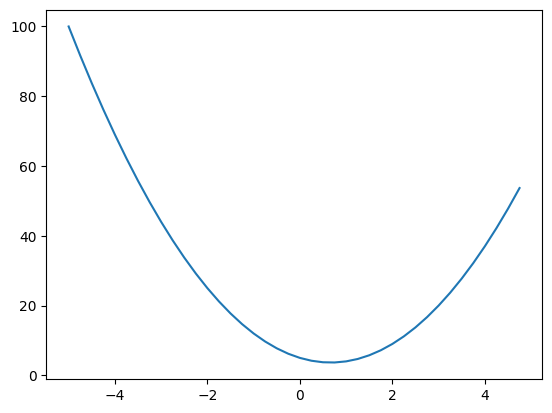

In [3]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [4]:
h = 0.00001
x = 3.0
(f(x + h) - f(x)) / h

14.00003000000538

In [5]:
a = 2.0
b = -3.0
c = 10.0
h = 0.001

d1 = a*b + c
a += h
d2 = a*b + c

(d2 - d1)/h

-3.0000000000001137

In [6]:
class Value:
    def __init__(self, data, _children=[], _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, [self, other], '+')

        def _backward():
            # print('back', self)
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward

        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, [self, other], '*')

        def _backward():
            # print('back', self)
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out

    def __radd__(self, other):
        return self + other

    def __rmul__(self, other):
        return self * other

    def __truediv__(self, other): # self/other
        return self * other**-1

    def __neg__(self):
        return self * -1

    def __sub__(self, other):
        return self + (-other)

    def __exp__(self):
        x = self.data
        out = Value(math.exp(x), [self], 'exp')

        def _backward():
            # print('back', self)
            self.grad += out.data * out.grad
        out._backward = _backward

        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only accepting int/float powers for now"
        out = Value(self.data ** other, [self], f'**{other}')

        def _backward():
            # print('back', self)
            self.grad += other * out.data * out.grad / self.data
        out._backward = _backward

        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, [self], 'tanh')

        def _backward():
            # print('back', self)
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        
        return out

    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()
        


In [7]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b;    e.label='e'
d = e + c;    d.label='d'
f = Value(-2.0, label='f')
L = d*f;     L.label='L'
L

Value(data=-8.0)

In [8]:
L.backward()

In [9]:
from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR: Left to Right
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label ,n.data, n.grad), shape='record')
        if n._op:
            # if this value is a result of some operation, then create an op node for it 
            dot.node(name = uid + n._op, label = n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot


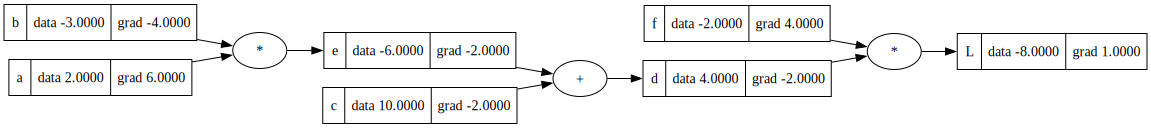

In [10]:
draw_dot(L)

In [11]:
# Manual way of doing it

L.grad = 1.0
L._backward()
d._backward()
e._backward()

In [12]:
# Automatic way of doing it

L.grad = 1.0

topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)

build_topo(L)

for node in reversed(topo):
    node._backward()


In [13]:
class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, x):
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]

class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return [p for n in self.neurons for p in n.parameters()]

class MLP:
    def __init__(self, nin, nout):
        sz = [nin] + nout
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nout))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]


In [14]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=0.39897283532235245)

In [15]:
len(n.parameters())

41

In [16]:
# Demo Data
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]
ys = [1.0, -1.0, -1.0, 1.0]

In [17]:
for k in range(50):
    # Forward Pass
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

    # Zero grad
    for p in n.parameters():
        p.grad = 0.0

    # Backward
    loss.backward()

    # Update
    for p in n.parameters():
        p.data -= 0.05 * p.grad

    print(k, loss.data)


0 6.500605212684301
1 3.5756600888086747
2 2.5561637115498588
3 0.6865512227487273
4 0.2616787667111866
5 0.16900881637858978
6 0.12518565344158125
7 0.0994384165611942
8 0.08246525082048034
9 0.07042689357402616
10 0.061442571767132026
11 0.05448065166826262
12 0.04892749657373903
13 0.04439505138999903
14 0.040625839740299395
15 0.03744227456563411
16 0.034717892622648426
17 0.03236018834595939
18 0.030299931530291348
19 0.02848427985631729
20 0.02687220092755797
21 0.025431347924307835
22 0.02413587734966701
23 0.022964893260096784
24 0.021901317711198832
25 0.020931057131155544
26 0.020042377951758932
27 0.01922543267447504
28 0.01847189571799267
29 0.01777468048327154
30 0.017127717261708537
31 0.01652577725131505
32 0.01596433188775438
33 0.015439439491013894
34 0.014947653234259832
35 0.014485945898578545
36 0.014051647947668227
37 0.013642396250924272
38 0.013256091378624383
39 0.012890861843016915
40 0.012545034002348958
41 0.012217106608700783
42 0.011905729184822796
43 0.011

In [18]:
ypred

[Value(data=0.9557531061848477),
 Value(data=-0.9782548881517698),
 Value(data=-0.934685857034831),
 Value(data=0.9416587571892958)]

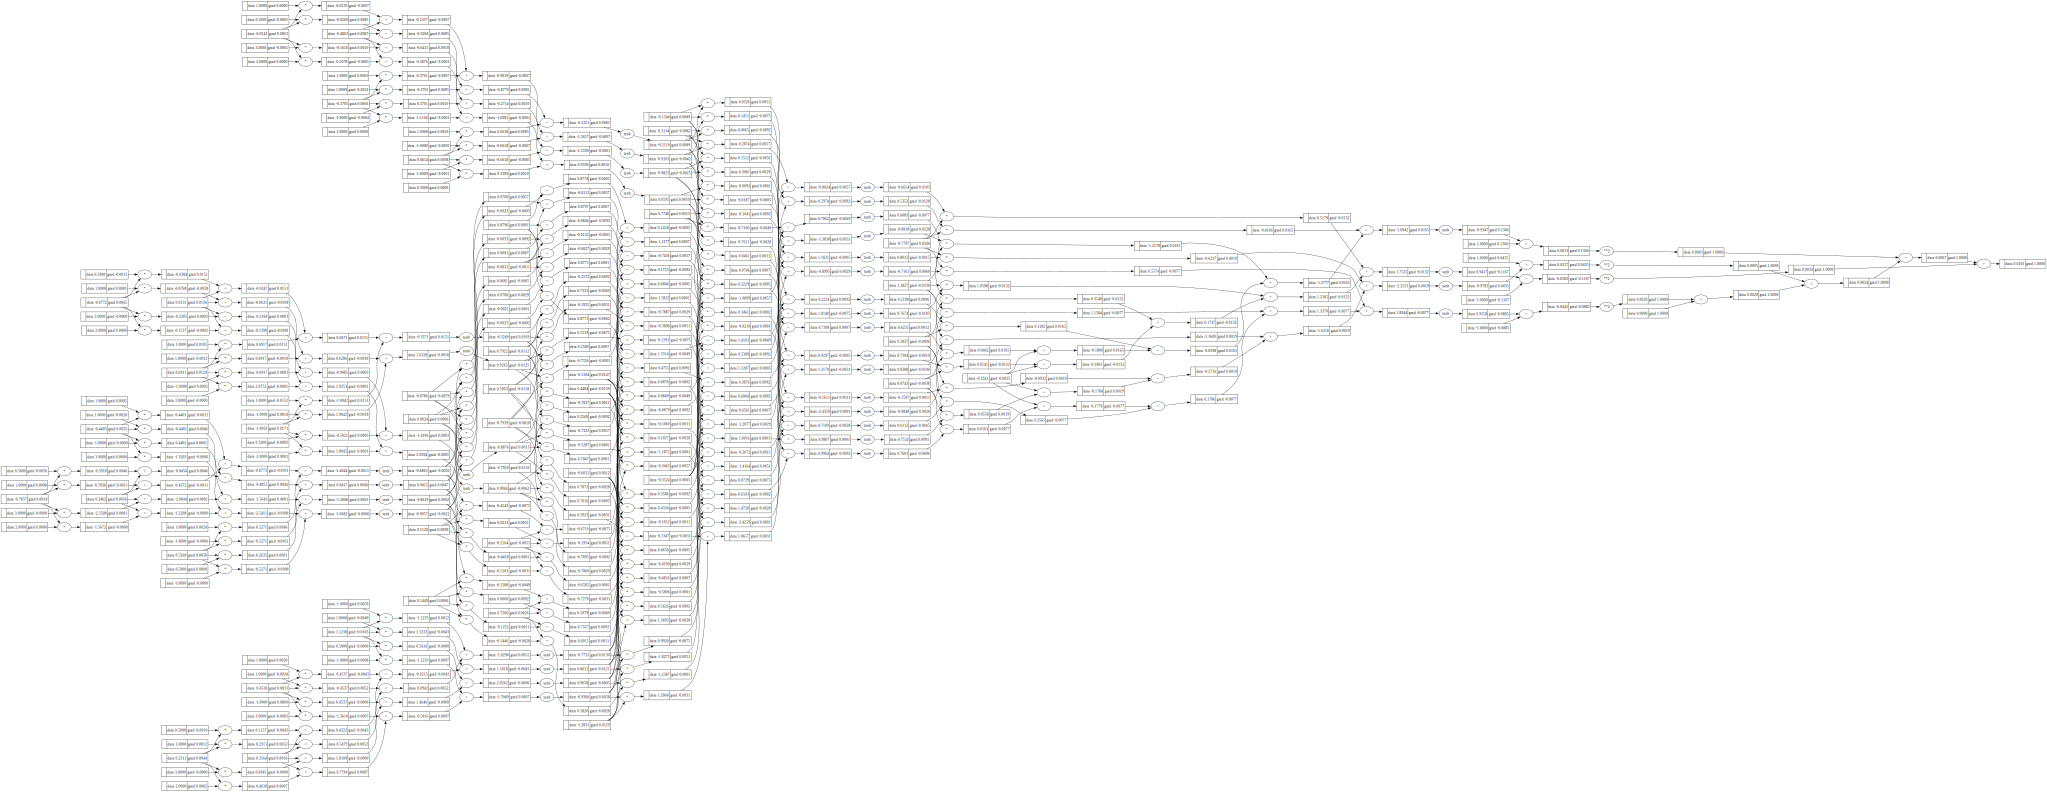

In [19]:
draw_dot(loss)